In [1]:
from typing import Callable, Tuple

from keras.datasets import mnist

from matplotlib import pyplot as plt
import numpy as np

import sklearn.preprocessing
import sklearn.metrics

from tqdm import tqdm

# Наши разработки из 3-ей работы))
from nn import Nums
from nn import NN, Layer
from nn.functions import cross_entropy, dsigmoid, sigmoid, softmax, relu, drelu
from nn.optimizers import AdamOptimizer, OptimizerBase, NoOptimizer, RMSPropOptimizer

type Nums = np.ndarray[np.number]
type NumsToNums = Callable[[Nums], Nums]
type NumsNumsToNums = Callable[[Nums, Nums], Nums]

np.set_printoptions(formatter={"float": lambda x: "{0:0.3f}".format(x)})

2024-12-10 16:20:31.918848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733836831.938112  348362 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733836831.943971  348362 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 16:20:31.964122: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Загружаем датасет, one-hot-encoding для меток классов

In [2]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

train_x = train_x / 255
test_x = test_x / 255

train_x.resize(60000, 784)
test_x.resize(10000, 784)

encoder = sklearn.preprocessing.OneHotEncoder()
train_y = encoder.fit_transform(train_y[..., None]).toarray()
test_y = encoder.fit_transform(test_y[..., None]).toarray()

train_x.shape, train_y.shape

((60000, 784), (60000, 10))

In [3]:
def get_views(x: Nums, window: Tuple[int, int], strides: Tuple[int, int]) -> Nums:
    # x - 3d
    output_shape = (np.subtract(x.shape[-2:], window) + strides) / strides
    output_shape = tuple(np.floor(output_shape, casting='unsafe', dtype=int))
    
    # (num_channels) x (output_shape) x (filter size)
    views_shape = (x.shape[0],) + output_shape + window
    
    channel_strides, row_strides, col_strides = x.strides
    
    views = np.lib.stride_tricks.as_strided(
        x, shape=views_shape, strides=(channel_strides, row_strides * strides[0], col_strides * strides[1], row_strides, col_strides)
    )
    return views
    

In [4]:
def add_padding(x: Nums, padding: Tuple[int, int]) -> Nums:
    # accepts 3d array
    return np.pad(x, ((0, 0), (padding[1], padding[1]), (padding[0], padding[0])))

def conv2d(x: Nums, filters: Nums, strides: Tuple[int, int]=(1, 1), padding: Tuple[int, int]=(0, 0)) -> Nums:
    """2д свёртка

    Args:
        x (Nums): Входной массив, 3d [каналы x ширина x высота]
        filters (Nums): Ядра свёртки, 3d [каналы x ширина x высота]
        strides (Tuple[int, int], optional): Шаги свёртки по x и y. Defaults to (1, 1).
        padding (Tuple[int, int], optional): Отступы по x и y. Defaults to (1, 1).

    Returns:
        Nums: Результат свёртки
    """
    assert x.shape[0] == filters.shape[0], f"num channels must be the same, {x.shape[0]} != {filters.shape[0]}"
    if padding != (0, 0):
        x = add_padding(x, padding)
    
    # x - кол-во каналов, x, y
    # filters - кол-во каналов, x, y
    
    output_shape = (np.subtract(x.shape[-2:], filters.shape[-2:]) + strides) / strides
    output_shape = tuple(np.floor(output_shape, casting='unsafe', dtype=int))
    
    # (num_channels) x (output_shape) x (filter size)
    views_shape = (x.shape[0],) + output_shape + filters.shape[-2:]
    
    channel_strides, row_strides, col_strides = x.strides
    
    views = np.lib.stride_tricks.as_strided(
        x, shape=views_shape, strides=(channel_strides, row_strides * strides[0], col_strides * strides[1], row_strides, col_strides)
        )
    # print(views, views.shape)
    return np.einsum('cijkl, ckl -> ij', views, filters)

In [5]:
def space_matrix(x, strides):
    shape_x, shape_y = x.shape[-2:]
    shape_x = (shape_x - 1) * strides[0] + 1
    shape_y = (shape_y - 1) * strides[1] + 1
    new_x = np.zeros((x.shape[:-2] + (shape_x, shape_y)))
    new_x[..., ::strides[0], ::strides[1]] = x
    return new_x

In [82]:
class MaxPool2DLayer:
    def __init__(
        self,
        window: Tuple[int, int],
        strides: Tuple[int, int],
        input_shape: Tuple[int, int, int]
    ) -> None:
        self.window = window
        self.strides = strides
        self.num_filters_in = input_shape[0]
        self.input_shape = input_shape

    def forward(self, x: Nums) -> Nums:
        # x - размерность [NumFilters x M x N]
        
        views = get_views(x, self.window, self.strides)
        t = np.max(views, axis=(-2, -1))
        
        # for i in range(len(x)):
        #     views = get_views(x[i], self.window, self.strides)
        #     out = np.max(views, axis=(-2, -1))
        #     t.append(out)
        #     calced.append(views)
        
        # t = np.array(t).reshape((x.shape[0], *self.output_shape))
        # self._calced = calced
        self.cache = x
        return t
        
    def backward(self, error: Nums) -> Nums:
        # error - размерность [NumFilters x M x N]
        
        x = self.cache
        
        de_dX = np.zeros(x.shape)
        
        views_to_write = get_views(de_dX, self.window, self.strides)
        views_to_read = get_views(x, self.window, self.strides)
        
        assert error.shape[0] == x.shape[0], f"num channels must be the same, {error.shape}, {x.shape}"

        for c in range(views_to_read.shape[0]):
            for i in range(views_to_read.shape[1]):
                for j in range(views_to_read.shape[2]):
                    idx = np.argmax(views_to_read[c, i, j])
                    views_to_write[c, i, j][np.unravel_index(idx, (2, 2))] += error[c, i, j]
        return de_dX

    def update(self, learning_rate: float):
        pass

    def set_optimizer(self, optimizer: OptimizerBase):
        pass

    def __repr__(self) -> str:
        return f"<Pooling2dLayer>"


In [41]:
from functools import reduce
from operator import mul


class Conv2DLayer:
    """
    Реализует свёрточный слой

    input_size: int - количество входных нейронов
    output_size: int - количество выходных нейронов
    weights: np.ndarray[np.number] - веса слоя
    bias: np.ndarray[np.number] - смещения

    self.activation_function: NumsToNums - функция активации слоя
    self.activation_function_derivation: NumsToNums - производная функции активации слоя
    """

    def __init__(
        self,
        filters_shape: Tuple[int, int, int, int],
        strides: Tuple[int, int],
        padding: Tuple[int, int],
        activation_function: Tuple[
            NumsToNums,
            NumsToNums,
        ],
        shape: Tuple[int, int],
        weights_initialize_function: Callable[[Tuple[int, int]], Nums] = None,
    ) -> None:
        if weights_initialize_function is None:
            weights_initialize_function = np.random.random

        self.num_filters = filters_shape[0]
        self.weights = weights_initialize_function(filters_shape)
        self.bias = weights_initialize_function((self.num_filters,))
        self.activation_function = activation_function[0]
        self.activation_function_derivation = activation_function[1]
        self.strides = strides
        self.padding = padding
        self.input_shape = shape
        self.input_shape_ravel = reduce(mul, shape)
        
        output_shape = (np.subtract(shape, filters_shape[-2:]) + strides) / strides
        self.output_shape = tuple(np.floor(output_shape, casting='unsafe', dtype=int))

        # Значения x и t, фиксируемые при forward, нужны для вычисления ошибки
        self.cache = None
        self._errors_log = ([], [])

    def forward(self, x: Nums) -> Nums:
        # x - размерность [NumFilters x M x N]
            
        t = np.zeros((self.num_filters, *self.output_shape))
        
        for i in range(self.num_filters):
            t[i] = conv2d(x, self.weights[i], strides=self.strides, padding=self.padding) + self.bias[i]
        
        h = self.activation_function(t)
        self.cache = (x, t)
        return h

    def backward(self, error: Nums) -> Nums:
        """
        Обратное распространение ошибки
        Запоминает производные ошибки, но не изменяет параметры модели
        Для изменения нужно вызвать update
        """
        x, t = self.cache
        
        # (5, 28, 28)
        
        de_dT = error * self.activation_function_derivation(t)
        views = get_views(x, self.weights.shape[-2:], self.strides)
        assert np.ndim(de_dT) == 3, f"invalid shape, {de_dT.shape}"
        
        de_dW = np.einsum('cijkl, oij->ockl', views, de_dT)
        
        de_dB = np.zeros_like(self.bias)
        for i in range(len(de_dT)):
            de_dB[i] = np.sum(de_dT[i])
        
        # print(de_dT.shape)
        assert de_dT.shape == (self.num_filters, *self.output_shape)
        
        de_dX = np.zeros(x.shape)
        views_to_write = get_views(de_dX, self.weights.shape[2:], self.strides)
        views_to_read = get_views(x, self.weights.shape[2:], self.strides)

        for c in range(len(de_dT)):
            for i in range(views_to_read.shape[1]):
                for j in range(views_to_read.shape[2]):
                    views_to_write[:, i, j] += de_dT[c, i, j] * self.weights[c]
        
        self._errors_log[0].append(de_dW)
        self._errors_log[1].append(de_dB)
        return de_dX

    def update(self, learning_rate: float):
        """
        Модифицирует веса модели
        learning_rate: float, [0, 1] - на сколько сильно модель будет реагировать на ошибку
        """
        de_dWs, de_dBs = self._errors_log
        de_dW = np.sum(de_dWs, axis=0)
        de_dB = np.sum(de_dBs, axis=0)

        self.optimizer.step(self.weights, self.bias, learning_rate, de_dW, de_dB)

        self._errors_log = ([], [])

    def set_optimizer(self, optimizer: OptimizerBase):
        optimizer.init_params(self.weights, self.bias)
        self.optimizer = optimizer

    def __repr__(self) -> str:
        return f"<Conv2dLayer, {self.weights.shape}>"


In [8]:
class FlattenLayer:
    def __init__(self, input_size):
        self.input_size = input_size
    
    def forward(self, x: Nums) -> Nums:
        return x.reshape((1, x.size))
    
    def backward(self, error: Nums) -> Nums:
        return error.reshape(self.input_size)
    
    def set_optimizer(self, optimizer):
        pass
    
    def update(self, lr):
        pass

In [83]:
from nn.functions import relu, drelu

# conv1 = Conv2DLayer((5, 3, 3), (1, 1), (1, 1), (relu, drelu), (28, 28))
# pool1 = MaxPool2DLayer((2, 2), (2, 2), (28, 28))
# # conv2 = Conv2DLayer((3, 3, 3), (1, 1), (1, 1), (relu, drelu), (14, 14))
# flat1 = FlattenLayer((5, 14, 14))
# mnn1 = Layer(5 * 14 * 14, 10, (softmax, lambda x: x),
#     weights_initialize_function=lambda shape: np.random.random(shape) * 0.01)



conv1 = Conv2DLayer((3, 1, 5, 5), (1, 1), (0, 0), (relu, drelu), (28, 28),
                    weights_initialize_function=lambda shape: np.random.random(shape) * 0.01)
pool1 = MaxPool2DLayer((2, 2), (2, 2), (3, 24, 24))
conv2 = Conv2DLayer((3, 3, 3, 3), (1, 1), (0, 0), (relu, drelu), (12, 12),
            weights_initialize_function=lambda shape: np.random.random(shape) * 0.01)
pool2 = MaxPool2DLayer((2, 2), (2, 2), (3, 10, 10))
flat1 = FlattenLayer((3, 5, 5))
mnn1 = Layer(3 * 5 * 5, 10, (softmax, lambda x: x),
    weights_initialize_function=lambda shape: np.random.random(shape) * 0.01,
)

the_y = train_x[0].reshape((1, 28, 28))

true_y = train_y[0]

print(the_y.shape)

conv1_t = the_y
the_y = conv1.forward(the_y)
print(the_y.shape)

the_y = pool1.forward(the_y)
print(the_y.shape)

the_y = conv2.forward(the_y)
print(the_y.shape)

the_y = pool2.forward(the_y)
print(the_y.shape)

the_y = flat1.forward(the_y)
print(the_y.shape)

the_y = mnn1.forward(the_y)
print(the_y.shape)

print("Backwards")

error = the_y - true_y

grad_mnn = mnn1.backward(error)
print("mnn", grad_mnn.shape)

grad_unflatten = flat1.backward(grad_mnn)
print("unflatten", grad_unflatten.shape)

grad_pool2 = pool2.backward(grad_unflatten)
print("pool2", grad_pool2.shape)

de_dW2 = conv2.backward(grad_pool2)
print("conv2", de_dW2.shape)

grad_pool1 = pool1.backward(de_dW2)
print("pool1", grad_pool1.shape)

de_dW1 = conv1.backward(grad_pool1)
print("conv1", de_dW1.shape)
# the_y = Conv2DLayer((3, 3, 3), (1, 1), (1, 1), (relu, drelu), (14, 14)).forward(the_y)
# print(the_y.shape)

(1, 28, 28)
(3, 24, 24)
(3, 12, 12)
(3, 10, 10)
(3, 5, 5)
(1, 75)
(1, 10)
Backwards
mnn (1, 75)
unflatten (3, 5, 5)
pool2 (3, 10, 10)
conv2 (3, 12, 12)
pool1 (3, 24, 24)
conv1 (1, 28, 28)


In [65]:
from nn import NN, Layer
from nn.functions import cross_entropy, dsigmoid, sigmoid, softmax

In [145]:
# expected 95%
from sklearn.metrics import root_mean_squared_error


network = NN(
    [
        # MaxPool2DLayer((2, 2), (2, 2), (24, 24)),
        # Conv2DLayer((3, 3, 3), (1, 1), (0, 0), (sigmoid, dsigmoid), (28, 28)),
        # Conv2DLayer((3, 1, 5, 5), (1, 1), (0, 0), (relu, drelu), (28, 28),
        #             weights_initialize_function=lambda shape: np.random.random(shape) * 0.01),
        # MaxPool2DLayer((2, 2), (2, 2), (3, 24, 24)),

        Conv2DLayer((32, 1, 3, 3), (1, 1), (0, 0), (relu, drelu), (28, 28),
                    weights_initialize_function=lambda shape: np.random.random(shape) * 0.01),
    
        MaxPool2DLayer((2, 2), (2, 2), (2, 26, 26)),
        
        Conv2DLayer((32, 32, 3, 3), (1, 1), (0, 0), (relu, drelu), (13, 13),
                    weights_initialize_function=lambda shape: np.random.random(shape) * 0.01),
        MaxPool2DLayer((2, 2), (2, 2), (32, 11, 11)),
        
        Conv2DLayer((12, 32, 3, 3), (1, 1), (0, 0), (relu, drelu), (5, 5),
                    weights_initialize_function=lambda shape: np.random.random(shape) * 0.01),
        FlattenLayer((12, 3, 3)),
        
        # FlattenLayer((1, 28, 28)),
        # Layer(784, 64, (relu, drelu), weights_initialize_function=lambda shape: np.random.random(shape) * 0.01,),
        Layer(12 * 3 * 3, 10, (softmax, lambda x: x),
            weights_initialize_function=lambda shape: np.random.random(shape) * 0.01,
        ),
    ],
    loss_function=cross_entropy,
)

loss_history = []

In [146]:
network.forward(train_x[0].reshape((1, 28, 28)))

array([[0.100, 0.100, 0.100, 0.099, 0.101, 0.100, 0.100, 0.100, 0.100,
        0.100]])

In [ ]:
def train(
    network: NN,
    x: Nums,
    y: Nums,
    num_epoches: int,
    learning_rate: float,
    batch_size: int,
    loss_history: list
):
    bar = tqdm(range(1, num_epoches + 1), total=num_epoches)
    xy_indices = np.arange(len(x))
    for epoch in bar:
        network.predicted.clear()
        # В каждой эпохе изменим порядок обучающего датасета
        np.random.shuffle(xy_indices)

        # size - размер выборки для эпохи, ставлю 1000, чтобы быстрее видеть результат
        indices = np.random.choice(len(xy_indices), size=100, replace=False)

        epoch_x = x[indices]
        epoch_y = y[indices]
        
        network.train(
            epoch_x,
            epoch_y,
            lambda: AdamOptimizer(0.4, 0.999),
            learning_rate=learning_rate,
            batch_size=batch_size,
        )
        
        # Средний loss за эпоху
        loss = network.pop_loss(np.mean)
        loss_history.append(loss)

        bar.set_description(
            f"epoch: {epoch}, loss: {loss:.10f}"
        )
        network.losses.clear()
    return loss_history


loss_history = train(
    network, train_x.reshape((60000, 1, 28, 28)), train_y, 1000, 0.0003, 25, loss_history
)

epoch: 1, loss: 57.5635668436:   0%|          | 1/1000 [00:18<5:06:25, 18.40s/it]

In [133]:
def show_multiple(images):
    # plot images
    fig, axes = plt.subplots(1, len(images), figsize=(1.5*len(images),2))
    for i in range(len(images)):
        ax = axes[i]
        ax.imshow(images[i], cmap='gray')

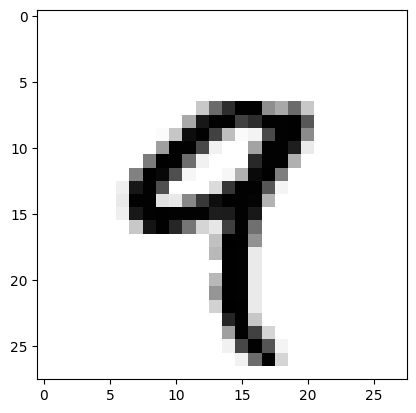

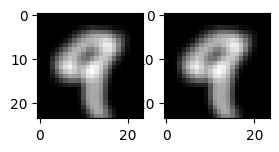

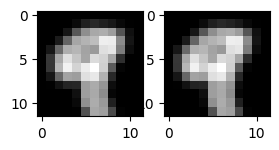

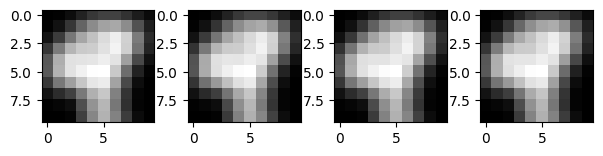

In [135]:
sample = train_x[4].reshape((1, 28, 28))

fig = plt.figure
plt.imshow(sample[0], cmap='gray_r')
plt.show()

after_conv_1 = network.layers[0].forward(sample)
show_multiple(after_conv_1)
after_max = network.layers[1].forward(after_conv_1)
show_multiple(after_max)
after_conv_2 = network.layers[2].forward(after_max)
show_multiple(after_conv_2)
# after_max_2 = network.layers[3].forward(after_conv_2)
# show_multiple(after_max_2)

plt.tight_layout()
plt.show()


In [ ]:
def forward_conv(self, X):
    """
        Performs a forward convolution.

        Parameters:
        - X : Last conv layer of shape (m, n_C_prev, n_H_prev, n_W_prev).

        Returns:
        - out: output of convolution.
    """
    self.cache = X
    m, n_C_prev, n_H_prev, n_W_prev = X.shape

    # Define output size.
    n_C = self.n_F
    n_H = int((n_H_prev + 2 * self.p - self.f)/ self.s) + 1
    n_W = int((n_W_prev + 2 * self.p - self.f)/ self.s) + 1

    out = np.zeros((m, n_C, n_H, n_W))

    for i in range(m): # For each image.

        for c in range(n_C): # For each channel.

            for h in range(n_H): # Slide the filter vertically.
                h_start = h * self.s
                h_end = h_start + self.f

                for w in range(n_W): # Slide the filter horizontally.                
                    w_start = w * self.s
                    w_end = w_start + self.f

                    # Element wise multiplication + sum.
                    out[i, c, h, w] = np.sum(X[i, :, h_start:h_end, w_start:w_end] 
                                    * self.W['val'][c, ...]) + self.b['val'][c]
    return out

In [ ]:
def backward(self, dout):
    """
        Distributes error from previous layer to convolutional layer and
        compute error for the current convolutional layer.
        Parameters:
        - dout: error from previous layer.

        Returns:
        - deltaL: error of the current convolutional layer.
    """
    X = self.cache

    m, n_C, n_H, n_W = X.shape
    m, n_C_dout, n_H_dout, n_W_dout = dout.shape

    dX = np.zeros(X.shape)

    #Compute dW.
    for i in range(m): # For each example.

        for c in range(n_C_dout): # For each channel.

            for h in range(n_H_dout): # Slide the filter vertically.
                h_start = h * self.s
                h_end = h_start + self.f

                for w in range(n_W_dout): #  Slide the filter horizontally.
                    w_start = w * self.s
                    w_end = w_start + self.f

                    self.W['grad'][c, ...] += dout[i, c, h, w] * X[i, :, h_start:h_end, w_start:w_end]
                    dX[i, :, h_start:h_end, w_start:w_end] += dout[i, c, h, w] * self.W['val'][c, ...]
    #Compute db.
    for c in range(self.n_F):
        self.b['grad'][c, ...] = np.sum(dout[:, c, ...])

    return dX, self.W['grad'], self.b['grad']

In [ ]:
from numpy import flip


class A:
    pass

weights = np.array([
    [
        [0, 1, 0],
        [1, 0, 1],
        [2, 1, 0]
    ],
    [
        [0, 1, 0],
        [1, 0, 1],
        [2, 1, 0]
    ]
])

weights = np.array([weights, flip(weights), weights, flip(weights)])
bias = np.ones((len(weights),))

obj = A()
obj.n_F = 4  # num filters
obj.s = 1  # strides
obj.f = 3  # kernel shape
obj.p = 0  # padding
obj.W = {'val': weights, 'grad': np.zeros_like(weights, dtype=np.float64)}
obj.b = {'val': bias, 'grad': np.zeros_like(bias, dtype=np.float64)}
weights.shape

(4, 2, 3, 3)

In [ ]:
test_a = np.array([
    [
        [0, 1, 2, 1, 0],
        [4, 1, 0, 1, 0],
        [2, 0, 1, 1, 1],
        [1, 2, 3, 1, 0],
        [0, 4, 3, 2, 0],
    ],
    np.flip(np.array([
        [0, 1, 2, 1, 0],
        [4, 1, 0, 1, 0],
        [2, 0, 1, 1, 1],
        [1, 2, 3, 1, 0],
        [0, 4, 3, 2, 0],
    ])),
])
# display(test_a)

fwd = forward_conv(obj, test_a.reshape((1, 2, 5, 5)))
# display(fwd, fwd.shape)

y = relu(fwd)

error = np.random.randint(1, 100, size=y.shape)
# error = np.ones_like(y)[0]
print("error_shape", error.shape)

de_dT = error * drelu(fwd)

print("grad to prev layer")
dx_true, dw_true, db_true = backward(obj, de_dT)
# de_dT = de_dT[0]

l = Conv2DLayer((4, 3, 3), (1, 1), (0, 0), (relu, drelu), (5, 5))
l.weights = weights
l.bias = obj.b['val']
q = l.forward(test_a.reshape(2, 5, 5))
# print("shape", error.shape)
dx = l.backward(error)
dw, db = l._errors_log

error_shape (1, 4, 3, 3)
grad to prev layer
(2, np.int64(3), np.int64(3), 3, 3)
(200, 40, 8, 40, 8)
(2, np.int64(3), np.int64(3), 3, 3)
(200, 40, 8, 40, 8)
(2, np.int64(3), np.int64(3), 3, 3)
(200, 40, 8, 40, 8)
(2, np.int64(3), np.int64(3), 3, 3)
(200, 40, 8, 40, 8)
(4, 3, 3)


In [ ]:
layer = MaxPool2DLayer((2, 2), (2, 2), (4, 3, 3))
pooled = layer.forward(q)
layer.backward(np.ones_like(pooled))
# views = get_views(q, (2, 2), (2, 2))
# t = np.max(views, axis=(-2, -1))

# pooled, pooled.shape, views.shape

array([[[1.000, 0.000, 0.000],
        [0.000, 0.000, 0.000],
        [0.000, 0.000, 0.000]],

       [[0.000, 1.000, 0.000],
        [0.000, 0.000, 0.000],
        [0.000, 0.000, 0.000]],

       [[1.000, 0.000, 0.000],
        [0.000, 0.000, 0.000],
        [0.000, 0.000, 0.000]],

       [[0.000, 1.000, 0.000],
        [0.000, 0.000, 0.000],
        [0.000, 0.000, 0.000]]])

In [ ]:
error = np.ones_like(pooled)
error

array([[[1.000]],

       [[1.000]],

       [[1.000]],

       [[1.000]]])

In [ ]:
views.shape

(4, 1, 1, 2, 2)

In [ ]:
de_dX = np.zeros((4, 3, 3))
views_to_write = get_views(de_dX, (2, 2), (2, 2))
views_to_read = get_views(q, (2, 2), (2, 2))

for c in range(len(views_to_read)):
    for i in range(views_to_read.shape[1]):
        for j in range(views_to_read.shape[2]):
            idx = np.argmax(views_to_read[c, i, j])
            views_to_write[c, i, j][np.unravel_index(idx, (2, 2))] += error[c, i, j]

de_dX

array([[[1.000, 0.000, 0.000],
        [0.000, 0.000, 0.000],
        [0.000, 0.000, 0.000]],

       [[0.000, 1.000, 0.000],
        [0.000, 0.000, 0.000],
        [0.000, 0.000, 0.000]],

       [[1.000, 0.000, 0.000],
        [0.000, 0.000, 0.000],
        [0.000, 0.000, 0.000]],

       [[0.000, 1.000, 0.000],
        [0.000, 0.000, 0.000],
        [0.000, 0.000, 0.000]]])

In [ ]:
obj.W['grad'] = np.zeros_like(obj.W['val'], dtype=np.float64)
obj.b['grad'] = np.zeros_like(obj.b['val'], dtype=np.float64)
_, dw, _ = backward(obj, de_dT)
dw

array([[[[703.000, 514.000, 350.000],
         [965.000, 674.000, 465.000],
         [1143.000, 1007.000, 780.000]],

        [[734.000, 883.000, 826.000],
         [507.000, 465.000, 909.000],
         [371.000, 575.000, 763.000]]],


       [[[536.000, 344.000, 219.000],
         [432.000, 571.000, 378.000],
         [962.000, 910.000, 597.000]],

        [[716.000, 980.000, 515.000],
         [588.000, 367.000, 437.000],
         [286.000, 358.000, 711.000]]],


       [[[784.000, 582.000, 542.000],
         [1162.000, 664.000, 598.000],
         [1088.000, 1180.000, 902.000]],

        [[678.000, 1002.000, 1289.000],
         [403.000, 677.000, 1069.000],
         [467.000, 632.000, 647.000]]],


       [[[502.000, 463.000, 322.000],
         [613.000, 371.000, 271.000],
         [680.000, 650.000, 440.000]],

        [[686.000, 958.000, 845.000],
         [469.000, 628.000, 773.000],
         [405.000, 330.000, 458.000]]]])

In [ ]:
de_dT.shape, weights.shape

((1, 4, 3, 3), (4, 2, 3, 3))

In [ ]:
de_dX = np.zeros(test_a.shape)
views_to_write = get_views(de_dX, weights.shape[2:], (1, 1))
views_to_read = get_views(test_a, weights.shape[2:], (1, 1))

for c in range(len(de_dT[0])):
    for i in range(views_to_read.shape[1]):
        for j in range(views_to_read.shape[2]):
            views_to_write[:, i, j] += de_dT[0, c, i, j] * weights[c]

de_dX

array([[[0.000, 234.000, 376.000, 331.000, 296.000],
        [234.000, 345.000, 917.000, 595.000, 355.000],
        [437.000, 838.000, 946.000, 985.000, 413.000],
        [470.000, 697.000, 1010.000, 351.000, 260.000],
        [256.000, 270.000, 458.000, 260.000, 0.000]],

       [[0.000, 234.000, 376.000, 331.000, 296.000],
        [234.000, 345.000, 917.000, 595.000, 355.000],
        [437.000, 838.000, 946.000, 985.000, 413.000],
        [470.000, 697.000, 1010.000, 351.000, 260.000],
        [256.000, 270.000, 458.000, 260.000, 0.000]]])

In [ ]:
de_dX = np.zeros(test_a.shape)
views_to_write = get_views(de_dX, weights.shape[2:], (1, 1))
views_to_read = get_views(test_a, weights.shape[2:], (1, 1))

for i in range(views_to_read.shape[1]):
    for j in range(views_to_read.shape[2]):
        views_to_write[:, i, j] += de_dT[0, :, i, j] * weights[:]

de_dX

ValueError: operands could not be broadcast together with shapes (4,) (4,2,3,3) 

In [ ]:
w0 = weights[0]

In [ ]:
views = get_views(add_padding(w0, (2, 2)), (3, 3), (1, 1))
print(views.shape)
# out = np.zeros((2, 5, 5))

# for c in range(len(de_dT[0])):
#     for i in range(views.shape[1]):
#         for j in range(views.shape[2]):
#             out[c, ...] += views[:, i, j] * de_dT[0, c, i, j]
# out
np.einsum('cijkl, okl->cij', views, de_dT[0])
# print(views.shape, de_dT[0].shape)
# out, out.shape

(2, 5, 5, 3, 3)


array([[[   0,  260,  148,  200,    0],
        [ 260,  351,  758,  375,  200],
        [ 723, 1055, 1096,  732,  227],
        [ 607,  917, 1187,  345,  234],
        [ 402,  437,  586,  234,    0]],

       [[   0,  260,  148,  200,    0],
        [ 260,  351,  758,  375,  200],
        [ 723, 1055, 1096,  732,  227],
        [ 607,  917, 1187,  345,  234],
        [ 402,  437,  586,  234,    0]]])

In [ ]:
views.shape

(2, 3, 3, 3, 3)

In [ ]:
for c in range(len(de_dT[0])):
    print(np.sum(de_dT[0, c]))

np.sum(de_dT[0], axis=0)

448
436
527
427


array([[190, 165, 133],
       [231, 151, 286],
       [221, 186, 275]])

In [ ]:
views = get_views(test_a, (3, 3), (1, 1))

out = np.zeros((4, 2, 3, 3))

for c in range(len(de_dT[0])):
    for i in range(views.shape[1]):
        for j in range(views.shape[2]):
            out[c, ...] += views[:, i, j] * de_dT[0, c, i, j]
out
assert (np.einsum('cijkl, oij->ockl', views, de_dT[0]) == out).all()
print(views.shape, de_dT[0].shape)
out, out.shape

(2, 3, 3, 3, 3) (4, 3, 3)


(array([[[[639.000, 411.000, 234.000],
          [635.000, 495.000, 400.000],
          [871.000, 874.000, 608.000]],
 
         [[676.000, 787.000, 686.000],
          [466.000, 432.000, 679.000],
          [305.000, 417.000, 622.000]]],
 
 
        [[[535.000, 380.000, 296.000],
          [741.000, 411.000, 320.000],
          [869.000, 732.000, 466.000]],
 
         [[601.000, 762.000, 799.000],
          [359.000, 412.000, 809.000],
          [332.000, 362.000, 615.000]]],
 
 
        [[[514.000, 378.000, 413.000],
          [823.000, 756.000, 587.000],
          [1157.000, 1211.000, 701.000]],
 
         [[694.000, 793.000, 748.000],
          [353.000, 376.000, 770.000],
          [378.000, 536.000, 799.000]]],
 
 
        [[[535.000, 462.000, 435.000],
          [892.000, 373.000, 375.000],
          [576.000, 674.000, 592.000]],
 
         [[449.000, 728.000, 1049.000],
          [240.000, 609.000, 864.000],
          [360.000, 425.000, 343.000]]]]),
 (4, 2, 3, 3))

In [ ]:
np.einsum('cijkl, oij->ockl', views, de_dT[0])

array([[[[ 639,  411,  234],
         [ 635,  495,  400],
         [ 871,  874,  608]],

        [[ 676,  787,  686],
         [ 466,  432,  679],
         [ 305,  417,  622]]],


       [[[ 535,  380,  296],
         [ 741,  411,  320],
         [ 869,  732,  466]],

        [[ 601,  762,  799],
         [ 359,  412,  809],
         [ 332,  362,  615]]],


       [[[ 514,  378,  413],
         [ 823,  756,  587],
         [1157, 1211,  701]],

        [[ 694,  793,  748],
         [ 353,  376,  770],
         [ 378,  536,  799]]],


       [[[ 535,  462,  435],
         [ 892,  373,  375],
         [ 576,  674,  592]],

        [[ 449,  728, 1049],
         [ 240,  609,  864],
         [ 360,  425,  343]]]])

In [ ]:
# def add_padding(x: Nums, padding: Tuple[int, int]) -> Nums:
#     # accepts 3d array
#     return np.pad(x, ((0, 0), (padding[1], padding[1]), (padding[0], padding[0])))

# def conv2d(x: Nums, filters: Nums, strides: Tuple[int, int]=(1, 1), padding: Tuple[int, int]=(0, 0)) -> Nums:
#     """2д свёртка

#     Args:
#         x (Nums): Входной массив, 3d
#         filters (Nums): Ядра свёртки, 3d
#         strides (Tuple[int, int], optional): Шаги свёртки по x и y. Defaults to (1, 1).
#         padding (Tuple[int, int], optional): Отступы по x и y. Defaults to (1, 1).

#     Returns:
#         Nums: Результат свёртки
#     """
#     assert x.shape[0] == filters.shape[0], f"num channels must be the same, {x.shape[0]} != {filters.shape[0]}"
#     if padding != (0, 0):
#         x = add_padding(x, padding)
    
#     # x - кол-во каналов, x, y
#     # filters - кол-во каналов, x, y
    
#     output_shape = (np.subtract(x.shape[-2:], filters.shape[-2:]) + strides) / strides
#     output_shape = tuple(np.floor(output_shape, casting='unsafe', dtype=int))
    
#     # (num_channels) x (output_shape) x (filter size)
#     views_shape = (x.shape[0],) + output_shape + filters.shape[-2:]
    
#     print(views_shape)
#     # 2 x 3 x 3
    
#     channel_strides, row_strides, col_strides = x.strides
#     print((channel_strides, row_strides * strides[0], col_strides * strides[1], row_strides, col_strides))
    
#     views = np.lib.stride_tricks.as_strided(
#         x, shape=views_shape, strides=(channel_strides, row_strides * strides[0], col_strides * strides[1], row_strides, col_strides)
#         )
#     # print(views, views.shape)
#     return np.einsum('cijkl, ckl -> ij', views, filters)

In [ ]:
# Допустим есть 2 канала 5 на 5
test_a.shape

(2, 5, 5)

In [ ]:
# Допустим есть 2 фильтра (2x3x3)
weights.shape

(2, 2, 3, 3)

In [ ]:
output = np.zeros((2, 3, 3))

for i in range(len(weights)):
    output[i] = conv2d(test_a, weights[i], strides=(1, 1), padding=(0, 0))

(2, np.int64(3), np.int64(3), 3, 3)
(200, 40, 8, 40, 8)
(2, np.int64(3), np.int64(3), 3, 3)
(200, 40, 8, 40, 8)
(2, np.int64(3), np.int64(3), 3, 3)
(200, 40, 8, 40, 8)


IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
output

array([[[17.000, 14.000, 14.000],
        [12.000, 14.000, 16.000],
        [10.000, 22.000, 21.000]],

       [[21.000, 22.000, 10.000],
        [16.000, 14.000, 12.000],
        [14.000, 14.000, 17.000]]])

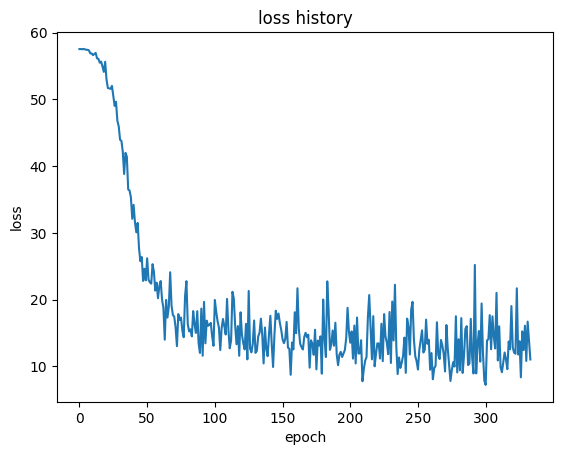

In [136]:
fig, ax = plt.subplots()

ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_title("loss history")
plt.show()

              precision    recall  f1-score   support

           0       0.90      0.97      0.94       980
           1       0.87      0.97      0.92      1135
           2       0.91      0.85      0.88      1032
           3       0.67      0.94      0.78      1010
           4       0.76      0.92      0.83       982
           5       0.83      0.72      0.77       892
           6       0.90      0.88      0.89       958
           7       0.91      0.86      0.88      1028
           8       0.89      0.62      0.73       974
           9       0.91      0.68      0.78      1009

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



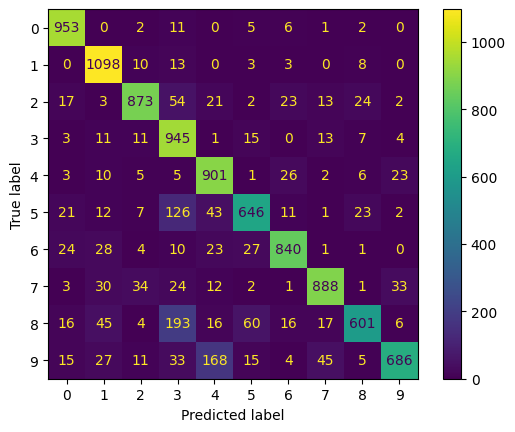

In [137]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = []
for i in range(len(test_x)):
    y_pred.append(network.forward(test_x[i].reshape((1, 28, 28)))[0])

y_pred_classes = [x for x in np.argmax(y_pred, axis=1)]
y_true_classes = [x for x in np.argmax(test_y, axis=1)]

print(sklearn.metrics.classification_report(y_true_classes, y_pred_classes))
ConfusionMatrixDisplay.from_predictions(y_true_classes, y_pred_classes)